In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
# Transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

In [4]:
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 11.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 337kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.21MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.24MB/s]


Training & Evaluation

In [5]:
def train_model(model, optimizer, criterion, epochs):
    train_acc, val_acc = [], []
    train_loss, val_loss = [], []

    for epoch in range(epochs):
        model.train()
        correct, total, running_loss = 0, 0, 0.0

        for data, target in train_loader:
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == target).sum().item()
            total += target.size(0)

        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_acc = correct / total

        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_acc)

        model.eval()
        correct, total, running_loss = 0, 0, 0.0

        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                outputs = model(data)
                loss = criterion(outputs, target)

                running_loss += loss.item()
                preds = outputs.argmax(dim=1)
                correct += (preds == target).sum().item()
                total += target.size(0)

        epoch_val_loss = running_loss / len(test_loader)
        epoch_val_acc = correct / total

        val_loss.append(epoch_val_loss)
        val_acc.append(epoch_val_acc)

        print(
            f"Epoch [{epoch+1}/{epochs}] | "
            f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f} | "
            f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}"
        )

    return train_acc, val_acc, train_loss, val_loss


Plot Training Curves

In [6]:
def plot_curves(train_acc, test_acc, train_loss, test_loss, title):
    plt.figure(figsize=(12,4))

    plt.subplot(1,2,1)
    plt.plot(train_acc, label="Train Acc")
    plt.plot(test_acc, label="Test Acc")
    plt.title(title + " Accuracy")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(train_loss, label="Train Loss")
    plt.plot(test_loss, label="Test Loss")
    plt.title(title + " Loss")
    plt.legend()

    plt.show()


CNN Model (Base Architecture)

In [7]:
class CNN(nn.Module):
    def __init__(self, activation=nn.ReLU, dropout=0.25):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3),
            activation(),
            nn.Conv2d(32, 64, 3),
            activation(),
            nn.MaxPool2d(2),
            nn.Dropout(dropout)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 12 * 12, 128),
            activation(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Task 1 – Activation Function Comparison



Sigmoid

Epoch [1/10] | Train Loss: 2.3011, Train Acc: 0.1135 | Val Loss: 2.2928, Val Acc: 0.1135
Epoch [2/10] | Train Loss: 2.2826, Train Acc: 0.1585 | Val Loss: 2.2556, Val Acc: 0.2609
Epoch [3/10] | Train Loss: 2.0811, Train Acc: 0.4138 | Val Loss: 1.6394, Val Acc: 0.6501
Epoch [4/10] | Train Loss: 1.1047, Train Acc: 0.7478 | Val Loss: 0.7328, Val Acc: 0.8330
Epoch [5/10] | Train Loss: 0.6190, Train Acc: 0.8469 | Val Loss: 0.4999, Val Acc: 0.8753
Epoch [6/10] | Train Loss: 0.4718, Train Acc: 0.8754 | Val Loss: 0.4116, Val Acc: 0.8894
Epoch [7/10] | Train Loss: 0.4059, Train Acc: 0.8869 | Val Loss: 0.3649, Val Acc: 0.9017
Epoch [8/10] | Train Loss: 0.3687, Train Acc: 0.8940 | Val Loss: 0.3386, Val Acc: 0.9033
Epoch [9/10] | Train Loss: 0.3436, Train Acc: 0.9007 | Val Loss: 0.3137, Val Acc: 0.9106
Epoch [10/10] | Train Loss: 0.3246, Train Acc: 0.9055 | Val Loss: 0.2975, Val Acc: 0.9146


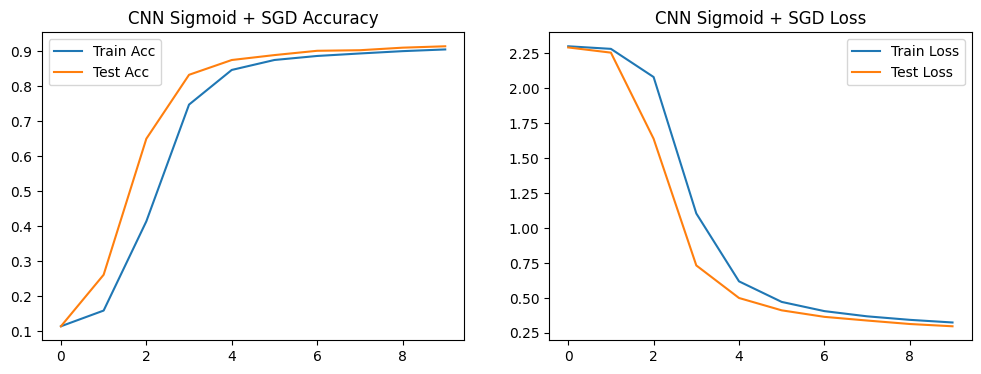

In [16]:
model_sigmoid = CNN(activation=nn.Sigmoid).to(device)
optimizer = optim.SGD(model_sigmoid.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

sig_tr_acc, sig_val_acc, sig_tr_loss, sig_val_loss = train_model(model_sigmoid, optimizer, criterion, 10)
plot_curves(sig_tr_acc, sig_val_acc, sig_tr_loss, sig_val_loss, "CNN Sigmoid + SGD")

Tanh

Epoch [1/10] | Train Loss: 0.4802, Train Acc: 0.8819 | Val Loss: 0.2623, Val Acc: 0.9250
Epoch [2/10] | Train Loss: 0.2378, Train Acc: 0.9323 | Val Loss: 0.1981, Val Acc: 0.9436
Epoch [3/10] | Train Loss: 0.1843, Train Acc: 0.9480 | Val Loss: 0.1571, Val Acc: 0.9549
Epoch [4/10] | Train Loss: 0.1491, Train Acc: 0.9577 | Val Loss: 0.1300, Val Acc: 0.9635
Epoch [5/10] | Train Loss: 0.1249, Train Acc: 0.9653 | Val Loss: 0.1123, Val Acc: 0.9678
Epoch [6/10] | Train Loss: 0.1067, Train Acc: 0.9701 | Val Loss: 0.0971, Val Acc: 0.9735
Epoch [7/10] | Train Loss: 0.0923, Train Acc: 0.9751 | Val Loss: 0.0870, Val Acc: 0.9749
Epoch [8/10] | Train Loss: 0.0812, Train Acc: 0.9780 | Val Loss: 0.0777, Val Acc: 0.9773
Epoch [9/10] | Train Loss: 0.0727, Train Acc: 0.9808 | Val Loss: 0.0708, Val Acc: 0.9784
Epoch [10/10] | Train Loss: 0.0655, Train Acc: 0.9826 | Val Loss: 0.0654, Val Acc: 0.9798


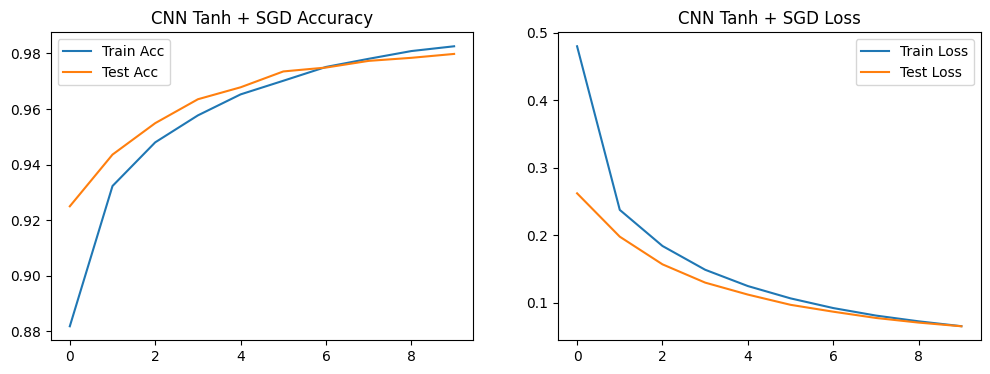

In [17]:
model_tanh = CNN(activation=nn.Tanh).to(device)
optimizer = optim.SGD(model_tanh.parameters(), lr=0.01)

tanh_tr_acc, tanh_val_acc, tanh_tr_loss, tanh_val_loss = train_model(model_tanh, optimizer, criterion, 10)
plot_curves(tanh_tr_acc, tanh_val_acc, tanh_tr_loss, tanh_val_loss, "CNN Tanh + SGD")

ReLU

Epoch [1/10] | Train Loss: 0.4194, Train Acc: 0.8796 | Val Loss: 0.2265, Val Acc: 0.9296
Epoch [2/10] | Train Loss: 0.1770, Train Acc: 0.9470 | Val Loss: 0.1330, Val Acc: 0.9612
Epoch [3/10] | Train Loss: 0.1215, Train Acc: 0.9637 | Val Loss: 0.0958, Val Acc: 0.9709
Epoch [4/10] | Train Loss: 0.0933, Train Acc: 0.9718 | Val Loss: 0.0792, Val Acc: 0.9741
Epoch [5/10] | Train Loss: 0.0762, Train Acc: 0.9766 | Val Loss: 0.0616, Val Acc: 0.9796
Epoch [6/10] | Train Loss: 0.0630, Train Acc: 0.9809 | Val Loss: 0.0596, Val Acc: 0.9801
Epoch [7/10] | Train Loss: 0.0546, Train Acc: 0.9832 | Val Loss: 0.0509, Val Acc: 0.9827
Epoch [8/10] | Train Loss: 0.0487, Train Acc: 0.9846 | Val Loss: 0.0492, Val Acc: 0.9830
Epoch [9/10] | Train Loss: 0.0421, Train Acc: 0.9869 | Val Loss: 0.0575, Val Acc: 0.9797
Epoch [10/10] | Train Loss: 0.0386, Train Acc: 0.9883 | Val Loss: 0.0413, Val Acc: 0.9846


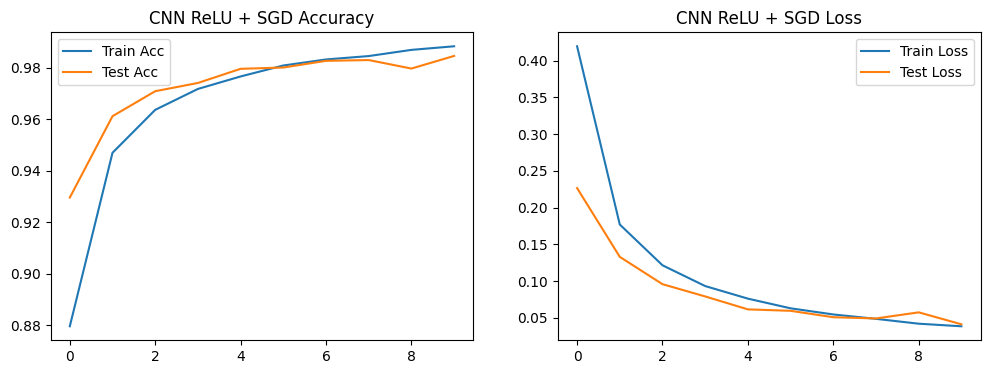

In [18]:
model_relu = CNN(activation=nn.ReLU).to(device)
optimizer = optim.SGD(model_relu.parameters(), lr=0.01)

relu_tr_acc, relu_val_acc, relu_tr_loss, relu_val_loss = train_model(model_relu, optimizer, criterion, 10)
plot_curves(relu_tr_acc, relu_val_acc, relu_tr_loss, relu_val_loss, "CNN ReLU + SGD")


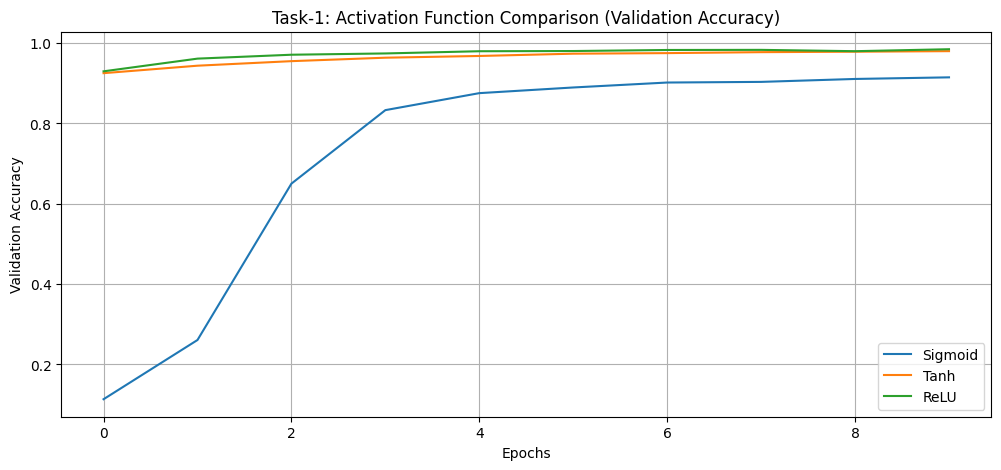

In [19]:
plt.figure(figsize=(12,5))

plt.plot(sig_val_acc, label="Sigmoid")
plt.plot(tanh_val_acc, label="Tanh")
plt.plot(relu_val_acc, label="ReLU")

plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.title("Task-1: Activation Function Comparison (Validation Accuracy)")
plt.legend()
plt.grid(True)
plt.show()


#Task 2 – Optimizer Comparison (ReLU Fixed)

In [14]:
criterion = nn.CrossEntropyLoss()
epochs = 10

SGD

In [15]:
model_sgd = CNN(activation=nn.ReLU).to(device)
optimizer_sgd = optim.SGD(model_sgd.parameters(), lr=0.01)

print("\nTraining with SGD\n")
sgd_tr_acc, sgd_val_acc, sgd_tr_loss, sgd_val_loss = train_model(
    model_sgd, optimizer_sgd, criterion, epochs
)



Training with SGD

Epoch [1/10] | Train Loss: 0.4282, Train Acc: 0.8770 | Val Loss: 0.1849, Val Acc: 0.9451
Epoch [2/10] | Train Loss: 0.1775, Train Acc: 0.9470 | Val Loss: 0.1227, Val Acc: 0.9636
Epoch [3/10] | Train Loss: 0.1203, Train Acc: 0.9642 | Val Loss: 0.0956, Val Acc: 0.9711
Epoch [4/10] | Train Loss: 0.0928, Train Acc: 0.9723 | Val Loss: 0.0815, Val Acc: 0.9734
Epoch [5/10] | Train Loss: 0.0750, Train Acc: 0.9777 | Val Loss: 0.0663, Val Acc: 0.9785
Epoch [6/10] | Train Loss: 0.0616, Train Acc: 0.9819 | Val Loss: 0.0512, Val Acc: 0.9819
Epoch [7/10] | Train Loss: 0.0536, Train Acc: 0.9835 | Val Loss: 0.0508, Val Acc: 0.9840
Epoch [8/10] | Train Loss: 0.0465, Train Acc: 0.9857 | Val Loss: 0.0593, Val Acc: 0.9803
Epoch [9/10] | Train Loss: 0.0417, Train Acc: 0.9875 | Val Loss: 0.0435, Val Acc: 0.9857
Epoch [10/10] | Train Loss: 0.0370, Train Acc: 0.9891 | Val Loss: 0.0412, Val Acc: 0.9856


SGD + Momentum

In [20]:
model_momentum = CNN(activation=nn.ReLU).to(device)
optimizer_momentum = optim.SGD(
    model_momentum.parameters(),
    lr=0.01,
    momentum=0.9
)

print("\nTraining with SGD + Momentum\n")
mom_tr_acc, mom_val_acc, mom_tr_loss, mom_val_loss = train_model(
    model_momentum, optimizer_momentum, criterion, epochs
)



Training with SGD + Momentum

Epoch [1/10] | Train Loss: 0.1929, Train Acc: 0.9433 | Val Loss: 0.0547, Val Acc: 0.9823
Epoch [2/10] | Train Loss: 0.0521, Train Acc: 0.9839 | Val Loss: 0.0347, Val Acc: 0.9884
Epoch [3/10] | Train Loss: 0.0346, Train Acc: 0.9893 | Val Loss: 0.0320, Val Acc: 0.9898
Epoch [4/10] | Train Loss: 0.0254, Train Acc: 0.9919 | Val Loss: 0.0329, Val Acc: 0.9896
Epoch [5/10] | Train Loss: 0.0191, Train Acc: 0.9942 | Val Loss: 0.0307, Val Acc: 0.9894
Epoch [6/10] | Train Loss: 0.0151, Train Acc: 0.9949 | Val Loss: 0.0295, Val Acc: 0.9904
Epoch [7/10] | Train Loss: 0.0124, Train Acc: 0.9960 | Val Loss: 0.0284, Val Acc: 0.9909
Epoch [8/10] | Train Loss: 0.0101, Train Acc: 0.9966 | Val Loss: 0.0357, Val Acc: 0.9899
Epoch [9/10] | Train Loss: 0.0073, Train Acc: 0.9975 | Val Loss: 0.0333, Val Acc: 0.9903
Epoch [10/10] | Train Loss: 0.0070, Train Acc: 0.9979 | Val Loss: 0.0341, Val Acc: 0.9901


Adam

In [21]:
model_adam = CNN(activation=nn.ReLU).to(device)
optimizer_adam = optim.Adam(model_adam.parameters(), lr=0.001)

print("\nTraining with Adam\n")
adam_tr_acc, adam_val_acc, adam_tr_loss, adam_val_loss = train_model(
    model_adam, optimizer_adam, criterion, epochs
)



Training with Adam

Epoch [1/10] | Train Loss: 0.1185, Train Acc: 0.9637 | Val Loss: 0.0480, Val Acc: 0.9846
Epoch [2/10] | Train Loss: 0.0425, Train Acc: 0.9862 | Val Loss: 0.0365, Val Acc: 0.9886
Epoch [3/10] | Train Loss: 0.0271, Train Acc: 0.9912 | Val Loss: 0.0374, Val Acc: 0.9882
Epoch [4/10] | Train Loss: 0.0196, Train Acc: 0.9930 | Val Loss: 0.0418, Val Acc: 0.9880
Epoch [5/10] | Train Loss: 0.0154, Train Acc: 0.9952 | Val Loss: 0.0408, Val Acc: 0.9887
Epoch [6/10] | Train Loss: 0.0134, Train Acc: 0.9955 | Val Loss: 0.0351, Val Acc: 0.9900
Epoch [7/10] | Train Loss: 0.0102, Train Acc: 0.9966 | Val Loss: 0.0480, Val Acc: 0.9893
Epoch [8/10] | Train Loss: 0.0093, Train Acc: 0.9969 | Val Loss: 0.0450, Val Acc: 0.9894
Epoch [9/10] | Train Loss: 0.0088, Train Acc: 0.9969 | Val Loss: 0.0423, Val Acc: 0.9883
Epoch [10/10] | Train Loss: 0.0069, Train Acc: 0.9977 | Val Loss: 0.0462, Val Acc: 0.9893


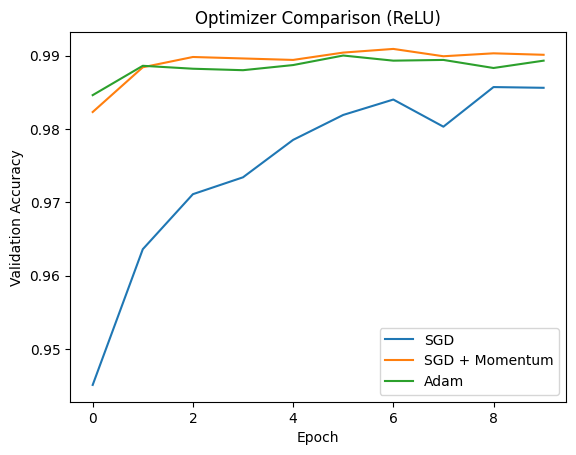

In [22]:
plt.plot(sgd_val_acc, label="SGD")
plt.plot(mom_val_acc, label="SGD + Momentum")
plt.plot(adam_val_acc, label="Adam")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.title("Optimizer Comparison (ReLU)")
plt.show()


MLP Model

In [23]:
class MLP(nn.Module):
    def __init__(self, layers, use_bn=True, dropout=0.0):
        super().__init__()
        modules = []
        input_dim = 28 * 28

        for units in layers:
            modules.append(nn.Linear(input_dim, units))
            if use_bn:
                modules.append(nn.BatchNorm1d(units))
            modules.append(nn.ReLU())
            if dropout > 0:
                modules.append(nn.Dropout(dropout))
            input_dim = units

        modules.append(nn.Linear(input_dim, 10))
        self.net = nn.Sequential(*modules)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.net(x)


#Task 3 – BN & Dropout Experiments

Without BN & Dropout

In [27]:
mlp1 = MLP([256], use_bn=False).to(device)
optimizer = optim.Adam(mlp1.parameters(), lr=0.001)

tr_acc_1, val_acc_1, tr_loss_1, val_loss_1 = train_model(mlp1, optimizer, criterion, 10)


Epoch [1/10] | Train Loss: 0.2274, Train Acc: 0.9332 | Val Loss: 0.1152, Val Acc: 0.9650
Epoch [2/10] | Train Loss: 0.0928, Train Acc: 0.9716 | Val Loss: 0.0795, Val Acc: 0.9744
Epoch [3/10] | Train Loss: 0.0666, Train Acc: 0.9788 | Val Loss: 0.0848, Val Acc: 0.9730
Epoch [4/10] | Train Loss: 0.0470, Train Acc: 0.9851 | Val Loss: 0.0852, Val Acc: 0.9750
Epoch [5/10] | Train Loss: 0.0395, Train Acc: 0.9869 | Val Loss: 0.0788, Val Acc: 0.9768
Epoch [6/10] | Train Loss: 0.0280, Train Acc: 0.9907 | Val Loss: 0.0781, Val Acc: 0.9769
Epoch [7/10] | Train Loss: 0.0244, Train Acc: 0.9919 | Val Loss: 0.0784, Val Acc: 0.9797
Epoch [8/10] | Train Loss: 0.0206, Train Acc: 0.9929 | Val Loss: 0.0901, Val Acc: 0.9784
Epoch [9/10] | Train Loss: 0.0189, Train Acc: 0.9935 | Val Loss: 0.0778, Val Acc: 0.9792
Epoch [10/10] | Train Loss: 0.0180, Train Acc: 0.9940 | Val Loss: 0.0991, Val Acc: 0.9780


Without BN, Dropout = 0.1

In [29]:
mlp2 = MLP([256], use_bn=False, dropout=0.1).to(device)
optimizer = optim.Adam(mlp2.parameters(), lr=0.001)

tr_acc_2, val_acc_2, tr_loss_2, val_loss_2 =train_model(mlp2, optimizer, criterion, 10)


Epoch [1/10] | Train Loss: 0.2352, Train Acc: 0.9306 | Val Loss: 0.1180, Val Acc: 0.9625
Epoch [2/10] | Train Loss: 0.1061, Train Acc: 0.9672 | Val Loss: 0.0852, Val Acc: 0.9736
Epoch [3/10] | Train Loss: 0.0749, Train Acc: 0.9769 | Val Loss: 0.0842, Val Acc: 0.9748
Epoch [4/10] | Train Loss: 0.0607, Train Acc: 0.9809 | Val Loss: 0.0747, Val Acc: 0.9773
Epoch [5/10] | Train Loss: 0.0498, Train Acc: 0.9840 | Val Loss: 0.0809, Val Acc: 0.9779
Epoch [6/10] | Train Loss: 0.0402, Train Acc: 0.9864 | Val Loss: 0.0779, Val Acc: 0.9775
Epoch [7/10] | Train Loss: 0.0373, Train Acc: 0.9879 | Val Loss: 0.0699, Val Acc: 0.9804
Epoch [8/10] | Train Loss: 0.0319, Train Acc: 0.9888 | Val Loss: 0.0770, Val Acc: 0.9789
Epoch [9/10] | Train Loss: 0.0274, Train Acc: 0.9906 | Val Loss: 0.0808, Val Acc: 0.9805
Epoch [10/10] | Train Loss: 0.0267, Train Acc: 0.9911 | Val Loss: 0.0806, Val Acc: 0.9785


With BN, Dropout = 0.25

In [30]:
mlp3 = MLP([256], use_bn=True, dropout=0.25).to(device)
optimizer = optim.Adam(mlp3.parameters(), lr=0.001)

tr_acc_3, val_acc_3, tr_loss_3, val_loss_3 =train_model(mlp3, optimizer, criterion, 10)


Epoch [1/10] | Train Loss: 0.2598, Train Acc: 0.9261 | Val Loss: 0.1236, Val Acc: 0.9641
Epoch [2/10] | Train Loss: 0.1344, Train Acc: 0.9604 | Val Loss: 0.0958, Val Acc: 0.9734
Epoch [3/10] | Train Loss: 0.1044, Train Acc: 0.9688 | Val Loss: 0.0797, Val Acc: 0.9755
Epoch [4/10] | Train Loss: 0.0874, Train Acc: 0.9733 | Val Loss: 0.0757, Val Acc: 0.9777
Epoch [5/10] | Train Loss: 0.0757, Train Acc: 0.9764 | Val Loss: 0.0725, Val Acc: 0.9776
Epoch [6/10] | Train Loss: 0.0664, Train Acc: 0.9788 | Val Loss: 0.0657, Val Acc: 0.9800
Epoch [7/10] | Train Loss: 0.0563, Train Acc: 0.9826 | Val Loss: 0.0664, Val Acc: 0.9794
Epoch [8/10] | Train Loss: 0.0551, Train Acc: 0.9825 | Val Loss: 0.0660, Val Acc: 0.9795
Epoch [9/10] | Train Loss: 0.0500, Train Acc: 0.9843 | Val Loss: 0.0623, Val Acc: 0.9816
Epoch [10/10] | Train Loss: 0.0438, Train Acc: 0.9859 | Val Loss: 0.0601, Val Acc: 0.9824


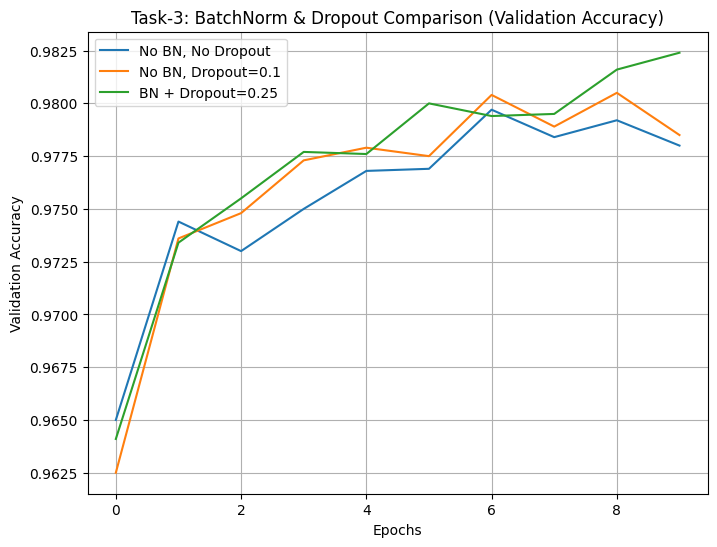

In [31]:
plt.figure(figsize=(8,6))

plt.plot(val_acc_1, label="No BN, No Dropout")
plt.plot(val_acc_2, label="No BN, Dropout=0.1")
plt.plot(val_acc_3, label="BN + Dropout=0.25")

plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.title("Task-3: BatchNorm & Dropout Comparison (Validation Accuracy)")
plt.legend()
plt.grid(True)
plt.show()


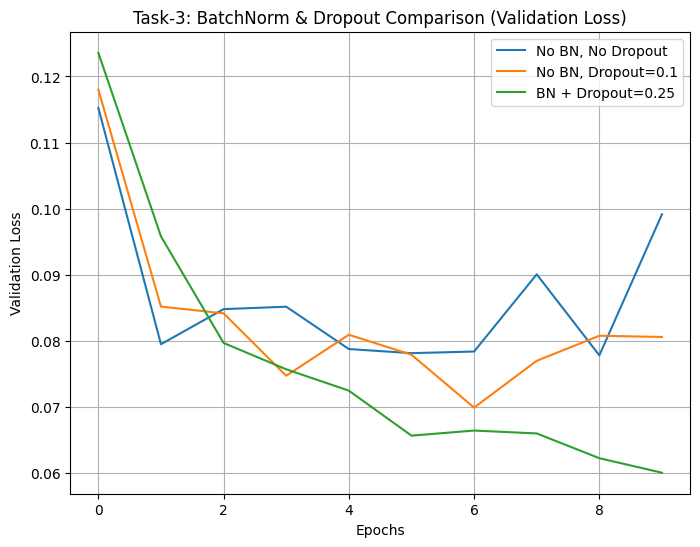

In [32]:
plt.figure(figsize=(8,6))

plt.plot(val_loss_1, label="No BN, No Dropout")
plt.plot(val_loss_2, label="No BN, Dropout=0.1")
plt.plot(val_loss_3, label="BN + Dropout=0.25")

plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.title("Task-3: BatchNorm & Dropout Comparison (Validation Loss)")
plt.legend()
plt.grid(True)
plt.show()


In [35]:
comparison_results = [
    # Task 1: Activation comparison
    ["Task-1", "Sigmoid", "SGD", 10, sig_val_acc[-1]],
    ["Task-1", "Tanh", "SGD", 10, tanh_val_acc[-1]],
    ["Task-1", "ReLU", "SGD", 10, relu_val_acc[-1]],

    # Task 2: Optimizer comparison (ReLU fixed)
    ["Task-2", "ReLU", "SGD", 10, sgd_val_acc[-1]],
    ["Task-2", "ReLU", "SGD + Momentum", 10, mom_val_acc[-1]],
    ["Task-2", "ReLU", "Adam", 10, adam_val_acc[-1]],

    # Task 3: BN & Dropout comparison (MLP)
    ["Task-3", "ReLU", "Adam", 10, val_acc_1[-1]],
    ["Task-3", "ReLU", "Adam", 10, val_acc_2[-1]],
    ["Task-3", "ReLU", "Adam", 10, val_acc_3[-1]],
]


In [38]:
import pandas as pd

df = pd.DataFrame(
    comparison_results,
    columns=[
        "Task",
        "Activation",
        "Optimizer",
        "Epochs",
        "Final_Val_Acc"
    ]
)

print(df.to_string(index=False))



  Task Activation      Optimizer  Epochs  Final_Val_Acc
Task-1    Sigmoid            SGD      10         0.9146
Task-1       Tanh            SGD      10         0.9798
Task-1       ReLU            SGD      10         0.9846
Task-2       ReLU            SGD      10         0.9856
Task-2       ReLU SGD + Momentum      10         0.9901
Task-2       ReLU           Adam      10         0.9893
Task-3       ReLU           Adam      10         0.9780
Task-3       ReLU           Adam      10         0.9785
Task-3       ReLU           Adam      10         0.9824


In [39]:
cnn1 = CNN(activation=nn.ReLU, dropout=0.25).to(device)
optimizer = optim.Adam(cnn1.parameters(), lr=0.001)

cnn_tr_acc, cnn_val_acc, cnn_tr_loss, cnn_val_loss = train_model(
    cnn1, optimizer, criterion, epochs=10
)



Epoch [1/10] | Train Loss: 0.1273, Train Acc: 0.9616 | Val Loss: 0.0456, Val Acc: 0.9843
Epoch [2/10] | Train Loss: 0.0422, Train Acc: 0.9866 | Val Loss: 0.0321, Val Acc: 0.9897
Epoch [3/10] | Train Loss: 0.0285, Train Acc: 0.9913 | Val Loss: 0.0410, Val Acc: 0.9869
Epoch [4/10] | Train Loss: 0.0212, Train Acc: 0.9932 | Val Loss: 0.0435, Val Acc: 0.9864
Epoch [5/10] | Train Loss: 0.0169, Train Acc: 0.9944 | Val Loss: 0.0351, Val Acc: 0.9895
Epoch [6/10] | Train Loss: 0.0129, Train Acc: 0.9958 | Val Loss: 0.0421, Val Acc: 0.9874
Epoch [7/10] | Train Loss: 0.0120, Train Acc: 0.9959 | Val Loss: 0.0335, Val Acc: 0.9901
Epoch [8/10] | Train Loss: 0.0090, Train Acc: 0.9971 | Val Loss: 0.0504, Val Acc: 0.9880
Epoch [9/10] | Train Loss: 0.0100, Train Acc: 0.9969 | Val Loss: 0.0438, Val Acc: 0.9895
Epoch [10/10] | Train Loss: 0.0087, Train Acc: 0.9972 | Val Loss: 0.0461, Val Acc: 0.9887


In [40]:
mlp1 = MLP(layers=[512, 256, 128], use_bn=True, dropout=0.0).to(device)
optimizer = optim.SGD(mlp1.parameters(), lr=0.01)

mlp1_tr_acc, mlp1_val_acc, mlp1_tr_loss, mlp1_val_loss = train_model(
    mlp1, optimizer, criterion, epochs=20
)



Epoch [1/20] | Train Loss: 0.4052, Train Acc: 0.9082 | Val Loss: 0.1561, Val Acc: 0.9604
Epoch [2/20] | Train Loss: 0.1455, Train Acc: 0.9613 | Val Loss: 0.1053, Val Acc: 0.9714
Epoch [3/20] | Train Loss: 0.0969, Train Acc: 0.9750 | Val Loss: 0.0833, Val Acc: 0.9759
Epoch [4/20] | Train Loss: 0.0692, Train Acc: 0.9828 | Val Loss: 0.0767, Val Acc: 0.9751
Epoch [5/20] | Train Loss: 0.0539, Train Acc: 0.9863 | Val Loss: 0.0676, Val Acc: 0.9785
Epoch [6/20] | Train Loss: 0.0409, Train Acc: 0.9905 | Val Loss: 0.0622, Val Acc: 0.9811
Epoch [7/20] | Train Loss: 0.0328, Train Acc: 0.9926 | Val Loss: 0.0612, Val Acc: 0.9817
Epoch [8/20] | Train Loss: 0.0268, Train Acc: 0.9944 | Val Loss: 0.0601, Val Acc: 0.9817
Epoch [9/20] | Train Loss: 0.0213, Train Acc: 0.9959 | Val Loss: 0.0598, Val Acc: 0.9818
Epoch [10/20] | Train Loss: 0.0176, Train Acc: 0.9968 | Val Loss: 0.0581, Val Acc: 0.9825
Epoch [11/20] | Train Loss: 0.0146, Train Acc: 0.9977 | Val Loss: 0.0574, Val Acc: 0.9827
Epoch [12/20] | Tra

In [41]:
mlp2 = MLP(layers=[256], use_bn=True, dropout=0.0).to(device)
optimizer = optim.Adam(mlp2.parameters(), lr=0.001)

mlp2_tr_acc, mlp2_val_acc, mlp2_tr_loss, mlp2_val_loss = train_model(
    mlp2, optimizer, criterion, epochs=15
)




Epoch [1/15] | Train Loss: 0.2276, Train Acc: 0.9369 | Val Loss: 0.1152, Val Acc: 0.9684
Epoch [2/15] | Train Loss: 0.1016, Train Acc: 0.9703 | Val Loss: 0.0880, Val Acc: 0.9744
Epoch [3/15] | Train Loss: 0.0708, Train Acc: 0.9787 | Val Loss: 0.0766, Val Acc: 0.9762
Epoch [4/15] | Train Loss: 0.0534, Train Acc: 0.9839 | Val Loss: 0.0708, Val Acc: 0.9770
Epoch [5/15] | Train Loss: 0.0405, Train Acc: 0.9877 | Val Loss: 0.0699, Val Acc: 0.9776
Epoch [6/15] | Train Loss: 0.0323, Train Acc: 0.9900 | Val Loss: 0.0642, Val Acc: 0.9795
Epoch [7/15] | Train Loss: 0.0271, Train Acc: 0.9919 | Val Loss: 0.0639, Val Acc: 0.9814
Epoch [8/15] | Train Loss: 0.0235, Train Acc: 0.9930 | Val Loss: 0.0657, Val Acc: 0.9800
Epoch [9/15] | Train Loss: 0.0205, Train Acc: 0.9936 | Val Loss: 0.0667, Val Acc: 0.9795
Epoch [10/15] | Train Loss: 0.0184, Train Acc: 0.9941 | Val Loss: 0.0665, Val Acc: 0.9808
Epoch [11/15] | Train Loss: 0.0147, Train Acc: 0.9956 | Val Loss: 0.0730, Val Acc: 0.9794
Epoch [12/15] | Tra

In [42]:
results = []


In [43]:
results.append([
    "CNN-1", 128, "Adam", 10,
    cnn_val_acc[-1],
    cnn_tr_acc, cnn_val_acc,
    cnn_tr_loss, cnn_val_loss
])

In [44]:

results.append([
    "MLP-1", "512-256-128", "SGD", 20,
    mlp1_val_acc[-1],
    mlp1_tr_acc, mlp1_val_acc,
    mlp1_tr_loss, mlp1_val_loss
])

In [45]:
results.append([
    "MLP-2", 256, "Adam", 15,
    mlp2_val_acc[-1],
    mlp2_tr_acc, mlp2_val_acc,
    mlp2_tr_loss, mlp2_val_loss
])

In [46]:
import pandas as pd

df = pd.DataFrame(
    results,
    columns=[
        "Model", "FC layer", "Optimizer", "Epochs",
        "Accuracy",
        "train_acc", "val_acc",
        "train_loss", "val_loss"
    ]
)

df["Accuracy"] = df["Accuracy"].round(4)

print(df[["Model", "FC layer", "Optimizer", "Epochs", "Accuracy"]].to_string(index=False))


Model    FC layer Optimizer  Epochs  Accuracy
CNN-1         128      Adam      10    0.9887
MLP-1 512-256-128       SGD      20    0.9825
MLP-2         256      Adam      15    0.9806


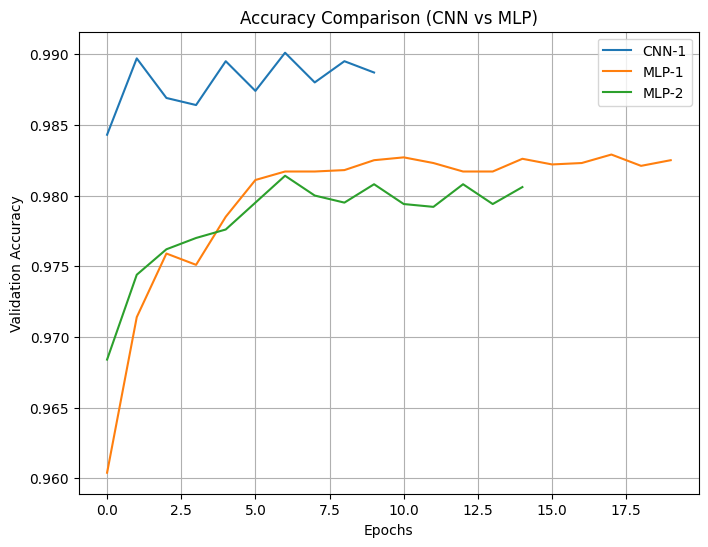

In [47]:
plt.figure(figsize=(8,6))

for r in results:
    plt.plot(r[6], label=r[0])   # r[6] = val_acc

plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.title("Accuracy Comparison (CNN vs MLP)")
plt.legend()
plt.grid(True)
plt.show()


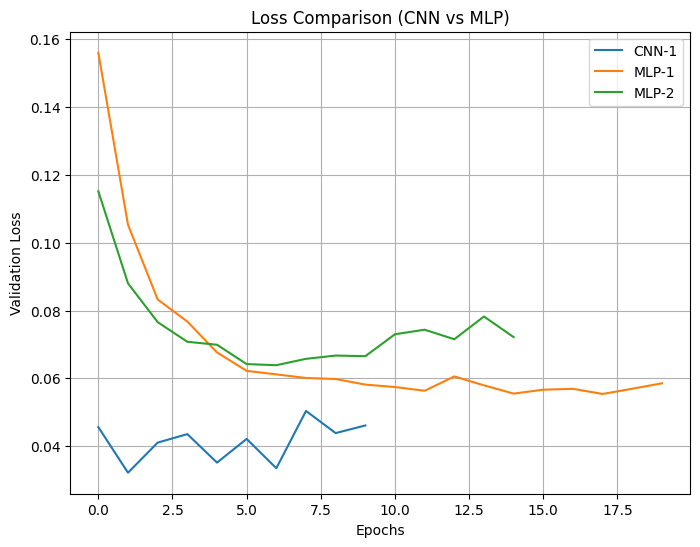

In [48]:
plt.figure(figsize=(8,6))

for r in results:
    plt.plot(r[8], label=r[0])   # r[8] = val_loss

plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.title("Loss Comparison (CNN vs MLP)")
plt.legend()
plt.grid(True)
plt.show()


Observations:

CNNs outperform MLPs for image-based tasks due to spatial feature learning.
ReLU is superior to sigmoid and tanh for deep networks.
Optimizer choice significantly affects convergence speed and final accuracy.
SGD with momentum can outperform Adam when tuned properly.
Regularization techniques such as Batch Normalization and Dropout improve model robustness and generalization.